In [ ]:
# Imports
import babypandas as bpd
import numpy as np
import math

import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')

# Animations
from IPython.display import display, IFrame

def show_bootstrapping_slides():
    src = "https://docs.google.com/presentation/d/e/2PACX-1vS_iYHJYXSVMMZ-YQVFwMEFR6EFN3FDSAvaMyUm-YJfLQgRMTHm3vI-wWJJ5999eFJq70nWp2hyItZg/embed?start=false&loop=false&delayms=3000"
    width = 960
    height = 509
    display(IFrame(src, width, height))
    
def show_confidence_interval_slides():
    src="https://docs.google.com/presentation/d/e/2PACX-1vTaPZsueXI6fey_5cj2Y1TevkR1joBvpwaWVsZNvgBlnJSrw1EiBLHJywkFH_QNLU5Tdr6JZgDrhFxG/embed?start=false&loop=false&delayms=3000"
    width = 960
    height = 989
    display(IFrame(src, width, height))

# Lecture 20 – Percentiles and Confidence Intervals

## DSC 10, Fall 2021

### Announcements

- Lab 6 due **Saturday 11/13 at 11:59pm**.
- Homework 6 will be released later today and will be due **Tuesday 11/16 at 11:59pm**.
- Tutor applications for next quarter are due on Friday! [Apply here](https://academicaffairs.ucsd.edu/Modules/ASES/Apply.aspx?cid=4371).
    - You can't tutor before your third quarter at UCSD (if you're not eligible now, apply in the winter for the spring)!

### Agenda

- Review: bootstrapping.
- Percentiles.
- Confidence intervals.
- Confidence intervals for hypothesis testing.

## Review: bootstrapping

**Goal:** Estimate the distribution of a sample statistic, given just a single sample.

In [ ]:
show_bootstrapping_slides()

### Recall: City of San Diego salary data

- We're interested in the median of all salaries (this is our population parameter).
- In this case we know it, but in reality we will not.

In [ ]:
population = bpd.read_csv('data/2020_salaries.csv')
population_median = population.get('TotalWages').median()
population_median

### Taking a single (large) random sample

In [ ]:
np.random.seed(23) # Ignore this
my_sample = population.sample(500, replace=False)
my_sample

### Bootstrapping

- Step 0: Collect a sample of the population – done.
- Step 1: Resample from the sample, **with replacement**, to create a new bootstrapped resample of the same size.
- Step 2: Compute the statistic on this resample and store it in an array.
- Step 3: Repeat Steps 1 and 2 many, many times.

In [ ]:
# Note that the population DataFrame doesn't appear anywhere here!

n_resamples = 500
boot_medians = np.array([])

for i in range(n_resamples):
    
    # Resample from my_sample
    resample = my_sample.sample(500, replace=True)
    
    # Compute the median
    median = resample.get('TotalWages').median()
    
    # Store it in our array of medians
    boot_medians = np.append(boot_medians, median)

In [ ]:
boot_medians

Now that we have this array of bootstrapped sample medians, we can visualize it.

In [ ]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
plt.scatter(population_median, 0.000004, color='orange', s=100, label='population median').set_zorder(2)
plt.legend();

- Again, we can only plot the orange dot because we happen to know the population parameter in this case (for teaching purposes).
    - In reality, you will not know the population parameter!

## Percentiles

### What's the point?

- We just learned how to approximate the distribution of a sample statistic.
- This means that we now have a sense of how much our estimates can vary.
- If someone asks, "what's your best guess of the population parameter?"
    - We're not just going to give them a single sample statistic.
    - We're not going to give them our entire bootstrapped distribution, either.
    - Instead, we may want to give them a range, or **interval**, of likely values for the population parameter.
- In order to talk about intervals, we need to talk about percentiles.

### Mathematical Definition

> Let $p$ be a number between 0 and 100. The $p$th percentile of a collection is the smallest value in the collection that is *at least as large* as $p$% of all the values. 

By this definition, any percentile between 0 and 100 can be computed for any collection of values and is always an element of the collection. 

### How to calculate percentiles using mathematical definition

Suppose there are $n$ elements in the collection. To find the $p$th percentile:

1. Sort the collection in increasing order.
2. Define $h$ to be $p\%$ of $n$: 

$$h = \frac p{100} \cdot n$$

3. If $h$ is an integer, define $k = h$. Otherwise, let $k$ be the smallest integer greater than $h$.

4. Take the $k$th element of the sorted collection
    - Start counting from 1, not 0.

### Example

What is the 25th percentile of the array `np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])`?

### Discussion Question

What is the 60th percentile of this sorted array?

`np.array([10, 18, 35, 45, 55, 56, 70, 89])`

- A. 45
- B. 53
- C. 55
- D. 60
- E. 70

### To answer, go to [menti.com](https://menti.com) and enter the code 9590 5895.

### Calculating the percentile using our mathematical definition

In [ ]:
def our_percentile(data, p):
    n = len(data)
    h = (p / 100) * n
    k = int(np.ceil(h)) # If h is an integer, this is h. Otherwise, rounds up.
    return data[k - 1] # -1 because Python is 0-indexed, but regular math is 1-indexed.

In [ ]:
our_percentile(np.arange(1, 11), 25)

### Another definition of percentile

- The `numpy` package provides a function to calculate percentiles, `np.percentile(array, p)`, which returns the `p`th percentile of `array`.
- The `numpy` method of calculating percentile is slightly different than ours.
    - The result need not be an element of the array. 
    - Details are unimportant, just know that our mathematical definition does not always match `np.percentile`!

In [ ]:
np.percentile(np.arange(1, 11), 25)

## Confidence intervals

### Confidence intervals


- Goal: estimate an unknown population parameter.
- We have been saying 
>"My guess for the population parameter is my sample statistic, $x$."
- We want to say 
>"My guess is that the population parameter is between $a$ and $b$."
- Let's use the bootstrapped distribution of an estimate to compute an **interval** that contains "the bulk" of the estimates.

### A 95% confidence interval for median salary

- Recall our bootstrapped distribution of the sample median.
- Suppose by "bulk", we mean containing the middle 95% of the area.

In [ ]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
plt.scatter(population_median, 0.000004, color='orange', s=100, label='population median').set_zorder(2)
plt.legend();

### Finding endpoints

- We want to find two points, $x$ and $y$, such that the area:
    - to the left of $x$ is about 2.5%.
    - to the right of $y$ is about 2.5%.
- The interval $[x,y]$ will contain about 95% of the total area, i.e. **95% of the total values**.
- $x$ and $y$ are the 2.5th percentile and 97.5th percentile, respectively.

In [ ]:
# Left endpoint
left = np.percentile(boot_medians, 2.5)
left

In [ ]:
# Right endpoint
right = np.percentile(boot_medians, 97.5)
right

In [ ]:
# Therefore, our interval is
[left, right]

You will use the code above **very** frequently moving forward!

### Visualizing our 95% confidence interval

- Let's draw the interval we just computed on the histogram.
- 95% of the bootstrap medians fell into this interval.

In [ ]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
plt.plot([left, right], [0, 0], color='lime', linewidth=12, label='95% confidence interval');
plt.scatter(population_median, 0.000004, color='orange', s=100, label='population median').set_zorder(3)
plt.legend();

- In this case, our 95% confidence interval (lime green) contains the true population parameter (orange dot).
    - It won't always, because you might have a bad original sample!
    - In reality, you won't know where the population parameter is, and so you won't know if your confidence interval contains it.

### Discussion Question

Would an 80% confidence interval be wider, narrower, or the same size as our 95% confidence interval?

- A. Wider
- B. Narrower
- C. The same size

### To answer, go to [menti.com](https://menti.com) and enter the code 9590 5895.

## Interpreting confidence intervals

### Interpreting confidence intervals

- 95% of our bootstrap medians fell within this interval.
- We're pretty confident that the true median does, too.
- How confident should we be about this? **What does a 95% confidence interval mean?**

### Capturing the true value

- Consider the process of:
    - Collecting a **new original sample** from the population,
    - Bootstrap resampling from it many times, computing the statistic (e.g. median) in each resample, and
    - Constructing a new 95% confidence interval.
- What a 95% confidence level states is that **approximately 95% of the time, the intervals you create through this process will contain the true population parameter**.
- The confidence is in **the process** that generates the interval.

### Many confidence intervals

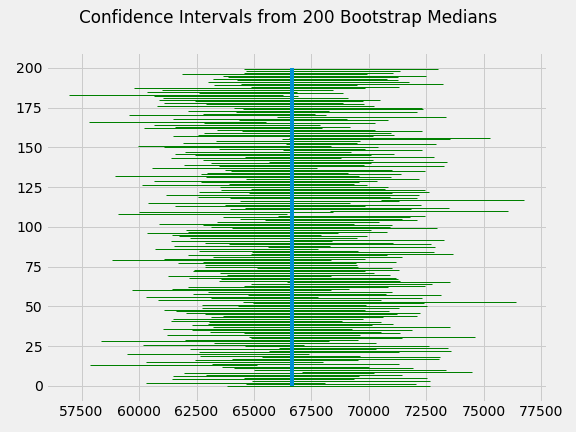

- The blue line represents the population parameter (it is slightly off, since it uses old data).
- The green lines represent **200** confidence intervals that result from repeating this process several times: 
    - new original sample  
    - new distribution of bootstrapped medians  
    - new confidence interval
- Most of them contain the true parameter – but not all!

### Which confidence intervals don't contain the true parameter?


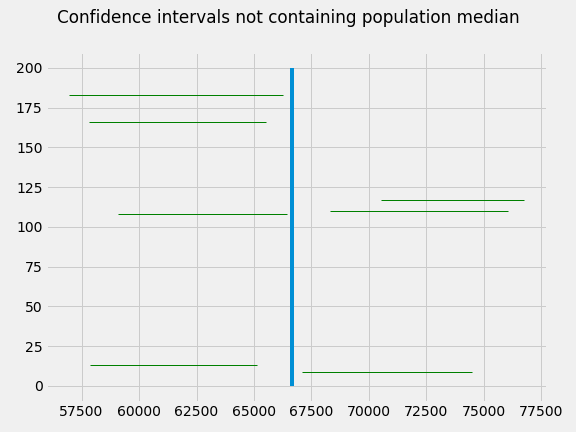

- 7 of my 200 confidence intervals didn't contain the true parameter.
- That means 193/200, or 96.5% of them, did.
    - Pretty close to 95%!
- In reality, you will have **no way of knowing if your confidence interval contains the true parameter**, since you never know if your original sample is good.

### Misinterpreting confidence intervals

In [ ]:
# Our interval
[left, right]

- It is **not true** that this interval contains 95% of all salaries.
- Instead, it is true that this interval contains 95% of all bootstrapped **median** salaries.

In [ ]:
population.plot(kind='hist', y='TotalWages', density=True, ec='w', figsize=(10, 5))
plt.plot([left, right], [0, 0], color='lime', linewidth=10, label='95% confidence interval');
plt.legend();

### Misinterpreting confidence intervals

In [ ]:
# Our interval
[left, right]

- It is **not true** that there is a 95% chance that this interval contains the population parameter.
    - The population parameter is fixed. In reality, we might not know it, but it is **not random**.
    - The interval above is not random, either.
    - Either the population parameter is in the interval, or it is not. There is no randomness involved.
- Remember that the 95% confidence is in the process that created an interval.
    - This process (sampling, then bootstrapping, then creating an interval) creates a good interval roughly 95% of the time.

In [ ]:
show_confidence_interval_slides()

## Confidence intervals and hypothesis testing

### Using a confidence interval for hypothesis testing

- **Null hypothesis**: The population parameter is equal to some value, $x$.
- **Alternative hypothesis**: The population parameter isn't equal to $x$.
- Cutoff for p-value: p%.
- Strategy:
    - Construct a (100-p)% confidence interval for the population parameter.
    - If $x$ is not in the interval, reject the null hypothesis.
    - If $x$ is in the interval, our results are consistent with the null (can't reject it).

### Example: Fire-Rescue Department 🚒

In [ ]:
fire_rescue_population = population[population.get('DepartmentOrSubdivision') == "Fire-Rescue"]
fire_rescue_population

### Just a sample
- Suppose we only have access to a sample of 300 Fire-Rescue Department workers.
- We want to understand the median salary of *all* Fire-Rescue Department workers.
- **Null hypothesis**: The median salary of Fire-Rescue Department workers is the same as the median of all San Diego city employee salaries, \$71,354.50.
- **Alternative hypothesis**: The median salary of Fire-Rescue Department workers is not the same as the median of all San Diego city employee salaries.
- We'll use a significance level (i.e. p-value cutoff) of 0.01, to be *really* sure.

In [ ]:
# The median salary of all City of SD employees, in all departments
population_median

In [ ]:
fire_rescue_sample = fire_rescue_population.sample(300, replace=False)
fire_rescue_sample

### Testing the hypotheses
- Since we're using a significance level of 0.01 = 1%, we need a 99% confidence interval for the median salary of Fire-Rescue Department workers.
- To construct a confidence interval, bootstrap and find middle 99% of distribution using `np.percentile`.

In [ ]:
n_resamples = 500

fire_rescue_medians = np.array([])
for i in range(n_resamples):
    
    # Resample from fire_rescue_sample
    resample = fire_rescue_sample.sample(300, replace=True)
    
    # Compute the median
    median = resample.get('TotalWages').median()
    
    # Add it to our array of bootstrapped medians
    fire_rescue_medians = np.append(fire_rescue_medians, median)

In [ ]:
fire_rescue_medians

### Finding the interval

In [ ]:
fire_left = np.percentile(fire_rescue_medians, 0.5)
fire_left

In [ ]:
fire_right = np.percentile(fire_rescue_medians, 99.5)
fire_right

In [ ]:
# Resulting interval
[fire_left, fire_right]

Is \$71,354.50 in this interval? 🤔

### Conclusion of the hypothesis test
- Since our 99% confidence interval did not contain the median of all San Diego city employee salaries, \$71,354.50, we reject the null.
- Fire-Rescue Department workers do not have the same median salary as other city employees.
- Can't say why.

In [ ]:
bpd.DataFrame().assign(FireRescueBootstrapMedians=fire_rescue_medians).plot(kind='hist', density=True, bins=np.arange(75000, 125000, 1000), ec='w', figsize=(10, 5))
plt.plot([fire_left, fire_right], [0, 0], color='lime', linewidth=12, label='95% confidence interval');
plt.legend();

In [ ]:
# Actual population median of Fire-Rescue Department salaries
fire_rescue_population.get('TotalWages').median()

## Summary

### Summary

- The $p$th percentile of a collection is the smallest value in the collection that is *at least as large* as $p$% of all the values. 
- After creating a bootstrapped distribution of a statistic, we can create a $c$% confidence interval by taking the middle $c$% of values of the bootstrapped distribution.
    - Interpretation: if you create many different c% confidence intervals, roughly c% of them will contain the true population parameter.
    - This method of creating confidence intervals is known as the **bootstrap percentile method**.
- We can use confidence intervals for hypothesis tests where the null hypothesis is that the population parameter is equal to some value.
- **Next time:** discussing center and spread (mean, median, and variance).